Notebook to train a fully convolutional network to detect nuclei and foci

## Imports

In [1]:
%matplotlib inline
from skimage import io
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from concurrent.futures import ProcessPoolExecutor

## Loading of training data

1 Physical GPUs, 1 Logical GPUs
Number of training images: 34848


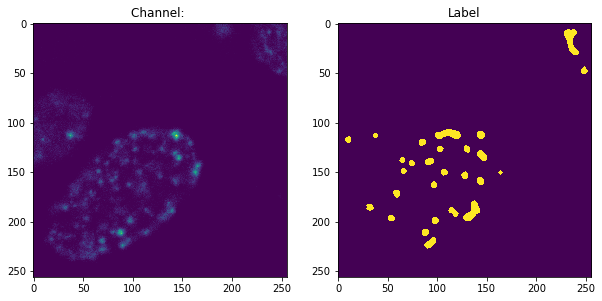

In [2]:
# Limit GPU Memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Reproducibility
SEED = 32
# Define folders containing training data
nucdetect_folder = os.path.join(os.path.expanduser("~"), "NucDetect")
train_dir = os.path.join(nucdetect_folder, "train")
label_dir = os.path.join(nucdetect_folder, "labels")

train = []
label = []
# Load blue channel
for f in os.listdir(train_dir):
    if "Red" in f:
        img = io.imread(os.path.join(train_dir, f))
        if img.shape == (1024, 1024):
            train.append(img[0:256, 0:256])
            train.append(img[0:256, 256:512])
            train.append(img[0:256, 512:768])
            train.append(img[0:256, 768:1024])
            train.append(img[256:512, 0:256])
            train.append(img[256:512, 256:512])
            train.append(img[256:512, 512:768])
            train.append(img[256:512, 768:1024])
            train.append(img[512:768, 0:256])
            train.append(img[512:768, 256:512])
            train.append(img[512:768, 512:768])
            train.append(img[512:768, 768:1024])
            train.append(img[768:1024, 0:256])
            train.append(img[768:1024, 256:512])
            train.append(img[768:1024, 512:768])
            train.append(img[768:1024, 768:1024])         

# Load labels
for f in os.listdir(label_dir):
    if "Red" in f:
        img = io.imread(os.path.join(label_dir, f))
        if img.shape == (1024, 1024):
            label.append(img[0:256, 0:256])
            label.append(img[0:256, 256:512])
            label.append(img[0:256, 512:768])
            label.append(img[0:256, 768:1024])
            label.append(img[256:512, 0:256])
            label.append(img[256:512, 256:512])
            label.append(img[256:512, 512:768])
            label.append(img[256:512, 768:1024])
            label.append(img[512:768, 0:256])
            label.append(img[512:768, 256:512])
            label.append(img[512:768, 512:768])
            label.append(img[512:768, 768:1024])
            label.append(img[768:1024, 0:256])
            label.append(img[768:1024, 256:512])
            label.append(img[768:1024, 512:768])
            label.append(img[768:1024, 768:1024])

train = np.asarray(train).astype("float32")
train /= 255
label = np.asarray(label).astype("float32")
label /= 255

print(f"Number of training images: {len(train)}")
# Show first image in train
fig, ax = plt.subplots(ncols=2, figsize=(10, 7.5))
ax[0].set_title(f"Channel: ")
ax[0].imshow(train[0])
ax[1].set_title("Label")
ax[1].imshow(label[0])
plt.show()

## Definition of FCN using Keras

In [3]:
LOAD_DIR = r"C:/tf_models"

# Load pretrained model
model = models.load_model(os.path.join(LOAD_DIR, "nucleus_detector.h5"))

# Show model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 25632       max_pooling2d[0][0]              
______________________________________________________________________________________________

Data shape: (34848, 256, 256, 1)
Label shape: (34848, 256, 256, 1)


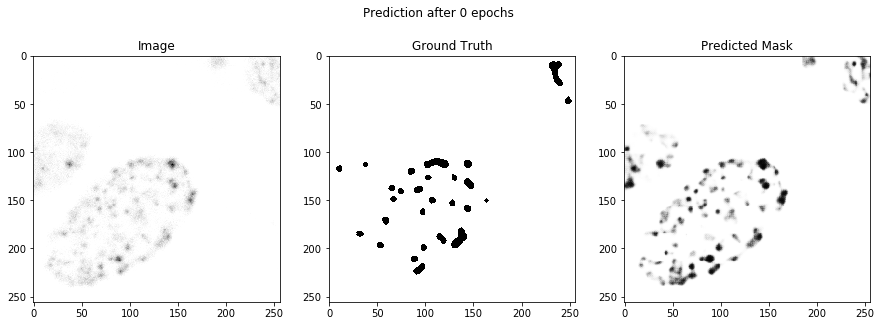

In [4]:
# Reshape data
train = train.reshape(-1, 256, 256, 1)
label = label.reshape(-1, 256, 256, 1)
print(f"Data shape: {train.shape}\nLabel shape: {label.shape}")

# Define function to create mask from model prediction
def create_mask(pred):
    # Get the whole output of the last layer
    mask = pred[0, :, :, 0]
    # Add a new axis to the prediction mask
    return mask[..., tf.newaxis]

# Define function to show predicted image
def show_prediction(epoch=0):
    # Get first train image
    img = train[0]
    lbl = label[0]
    # Create prediction mask for first image
    pred = create_mask(model.predict(img[tf.newaxis, ...]))
    # Create plot
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
    fig.suptitle(f"Prediction after {epoch} epochs")
    ax[0].imshow(tf.keras.preprocessing.image.array_to_img(img), cmap="binary")
    ax[0].set_title("Image")
    ax[1].imshow(tf.keras.preprocessing.image.array_to_img(lbl), cmap="binary")
    ax[1].set_title("Ground Truth")
    ax[2].imshow(tf.keras.preprocessing.image.array_to_img(pred), cmap="binary")
    ax[2].set_title("Predicted Mask")
    plt.show()


# Show prediction without training
show_prediction()

Train on 31363 samples, validate on 3485 samples
Epoch 1/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0468 - accuracy: 0.9820

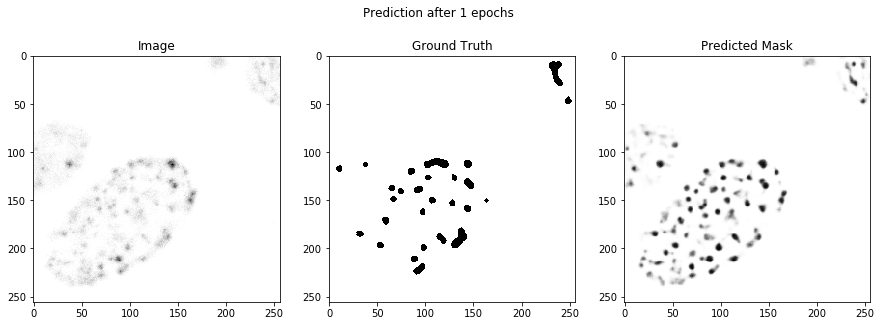

31363/31363 [==============================] - 188s 6ms/sample - loss: 0.0468 - accuracy: 0.9820 - val_loss: 0.0430 - val_accuracy: 0.9828
Epoch 2/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0427 - accuracy: 0.9830

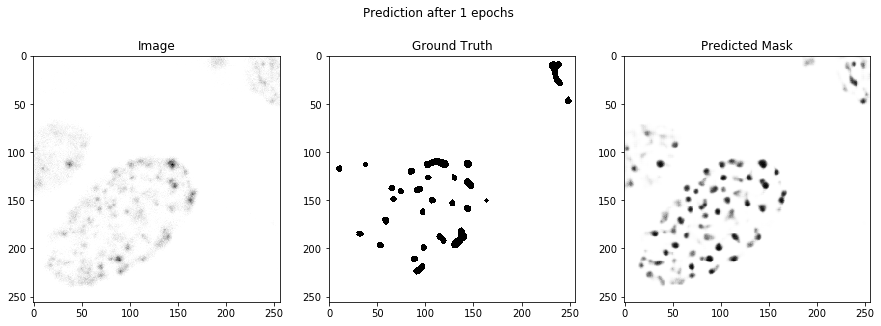

31363/31363 [==============================] - 186s 6ms/sample - loss: 0.0427 - accuracy: 0.9830 - val_loss: 0.0410 - val_accuracy: 0.9834
Epoch 3/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0413 - accuracy: 0.9834

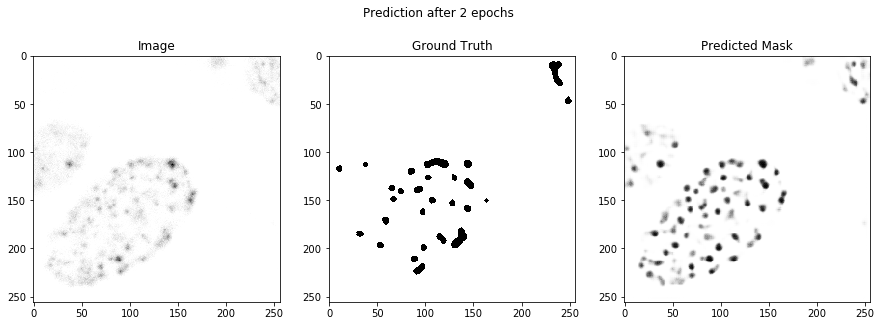

31363/31363 [==============================] - 186s 6ms/sample - loss: 0.0413 - accuracy: 0.9834 - val_loss: 0.0405 - val_accuracy: 0.9836
Epoch 4/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9836

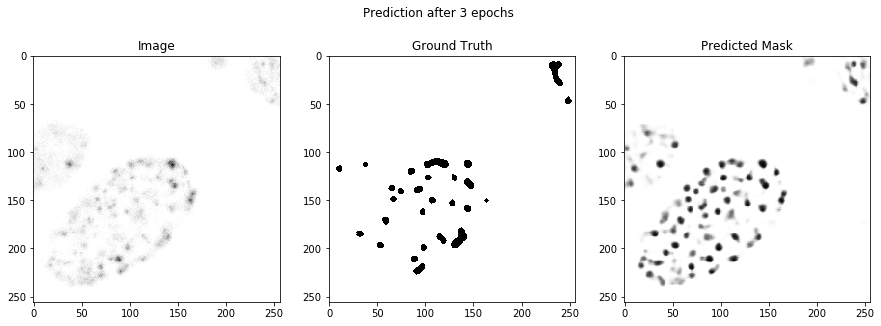

31363/31363 [==============================] - 187s 6ms/sample - loss: 0.0405 - accuracy: 0.9836 - val_loss: 0.0398 - val_accuracy: 0.9836
Epoch 5/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0401 - accuracy: 0.9838

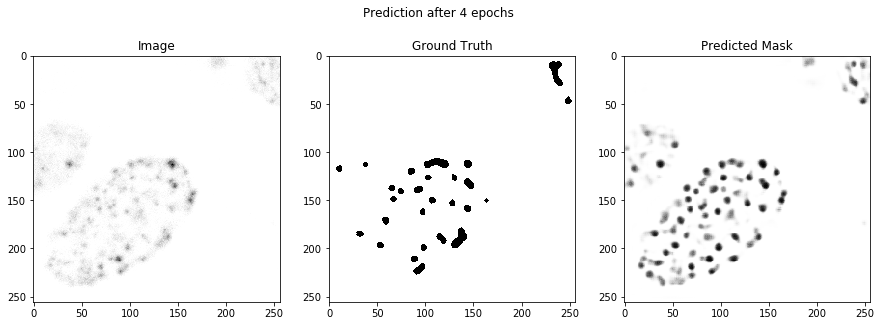

31363/31363 [==============================] - 187s 6ms/sample - loss: 0.0401 - accuracy: 0.9838 - val_loss: 0.0394 - val_accuracy: 0.9839
Epoch 6/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0395 - accuracy: 0.9840

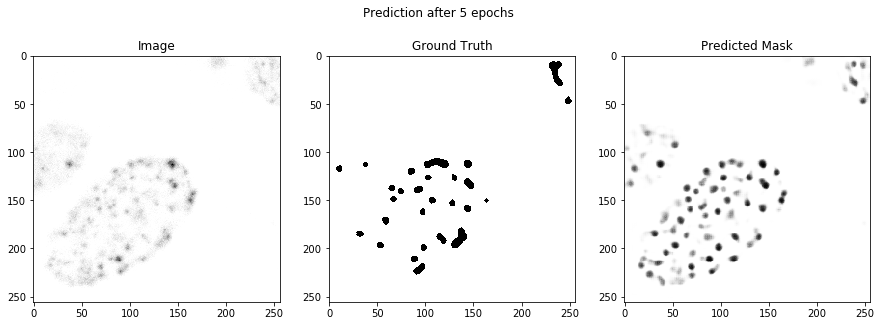

31363/31363 [==============================] - 187s 6ms/sample - loss: 0.0395 - accuracy: 0.9840 - val_loss: 0.0381 - val_accuracy: 0.9842
Epoch 7/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0391 - accuracy: 0.9841

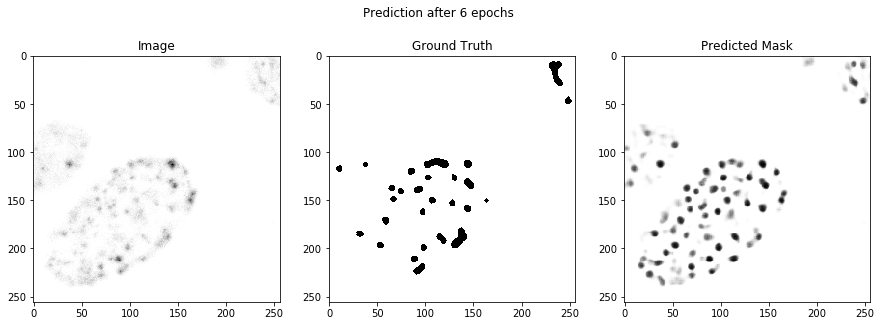

31363/31363 [==============================] - 187s 6ms/sample - loss: 0.0391 - accuracy: 0.9841 - val_loss: 0.0382 - val_accuracy: 0.9843
Epoch 8/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9843

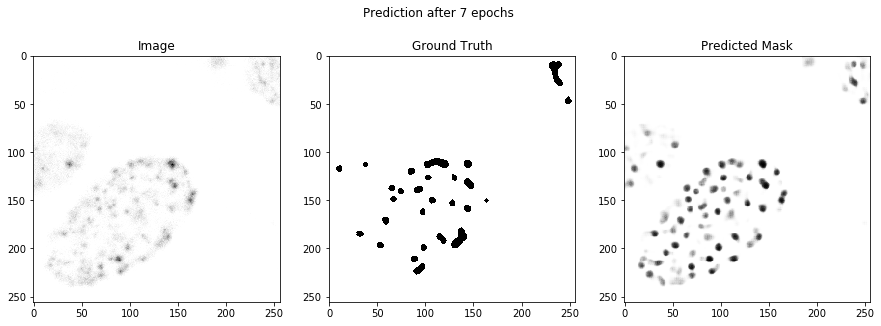

31363/31363 [==============================] - 187s 6ms/sample - loss: 0.0385 - accuracy: 0.9843 - val_loss: 0.0379 - val_accuracy: 0.9844
Epoch 9/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9843

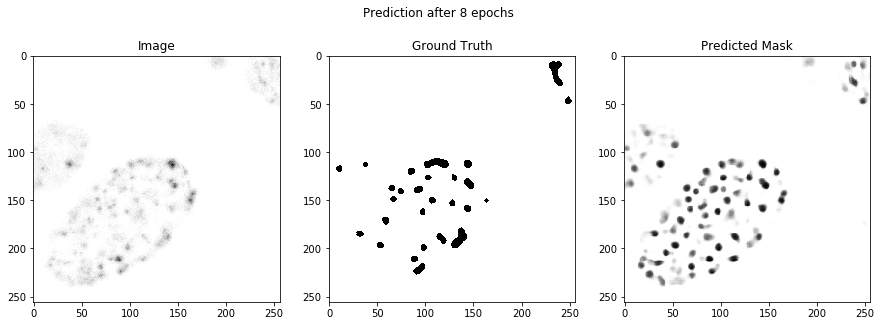

31363/31363 [==============================] - 187s 6ms/sample - loss: 0.0385 - accuracy: 0.9843 - val_loss: 0.0371 - val_accuracy: 0.9846
Epoch 10/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.9844

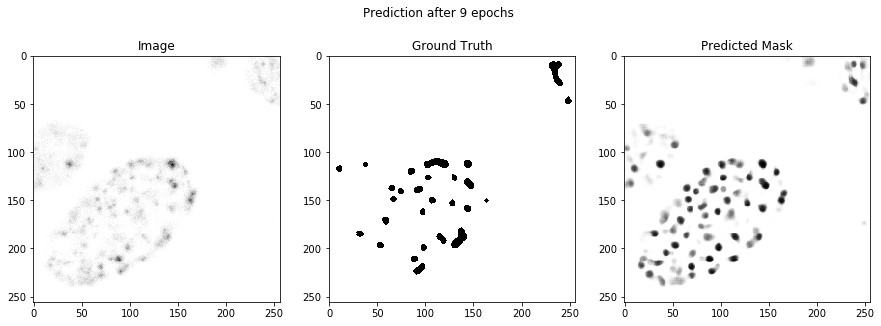

31363/31363 [==============================] - 187s 6ms/sample - loss: 0.0379 - accuracy: 0.9844 - val_loss: 0.0372 - val_accuracy: 0.9845
Epoch 11/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9845

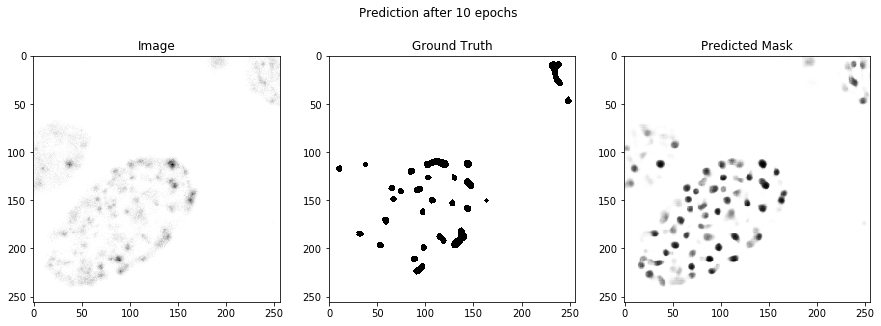

31363/31363 [==============================] - 187s 6ms/sample - loss: 0.0378 - accuracy: 0.9845 - val_loss: 0.0365 - val_accuracy: 0.9848
Epoch 12/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0375 - accuracy: 0.9846

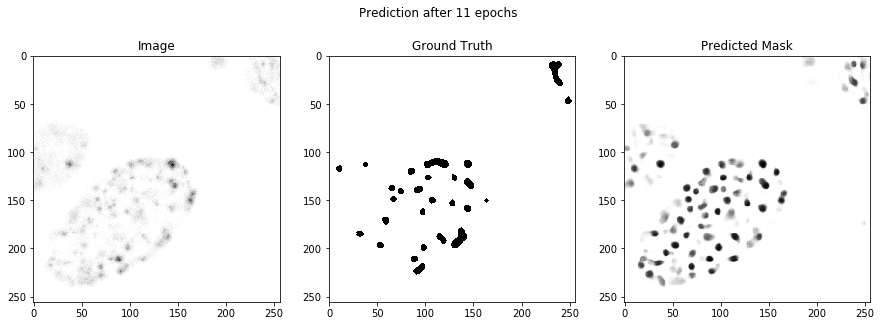

31363/31363 [==============================] - 187s 6ms/sample - loss: 0.0375 - accuracy: 0.9846 - val_loss: 0.0366 - val_accuracy: 0.9847
Epoch 13/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0372 - accuracy: 0.9847

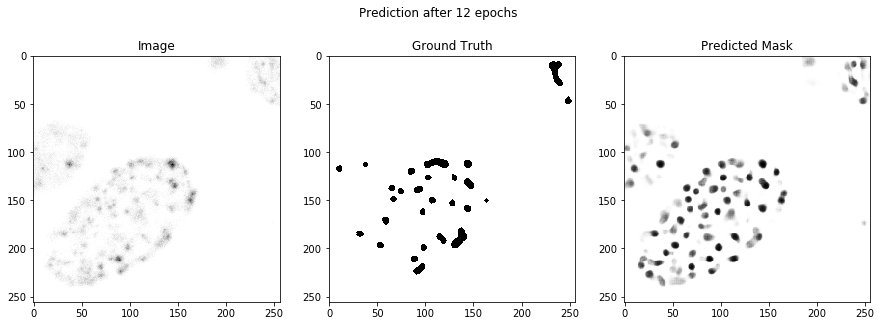

31363/31363 [==============================] - 187s 6ms/sample - loss: 0.0372 - accuracy: 0.9847 - val_loss: 0.0363 - val_accuracy: 0.9848
Epoch 14/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9848

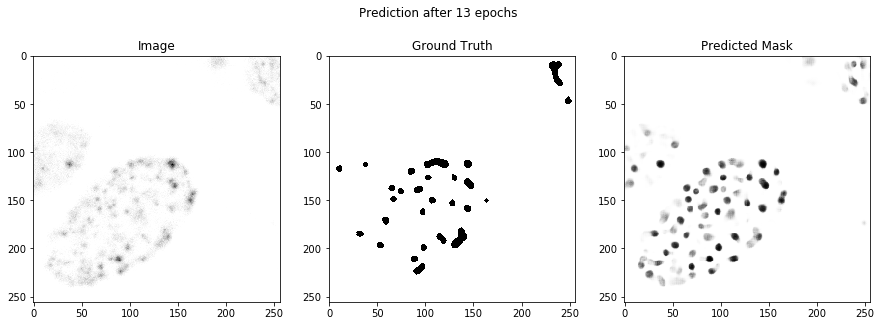

31363/31363 [==============================] - 187s 6ms/sample - loss: 0.0369 - accuracy: 0.9848 - val_loss: 0.0358 - val_accuracy: 0.9850
Epoch 15/15
31360/31363 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9849

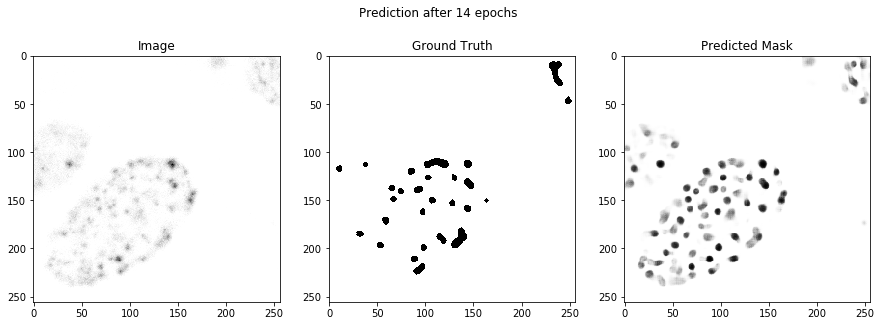

31363/31363 [==============================] - 183s 6ms/sample - loss: 0.0366 - accuracy: 0.9849 - val_loss: 0.0355 - val_accuracy: 0.9852


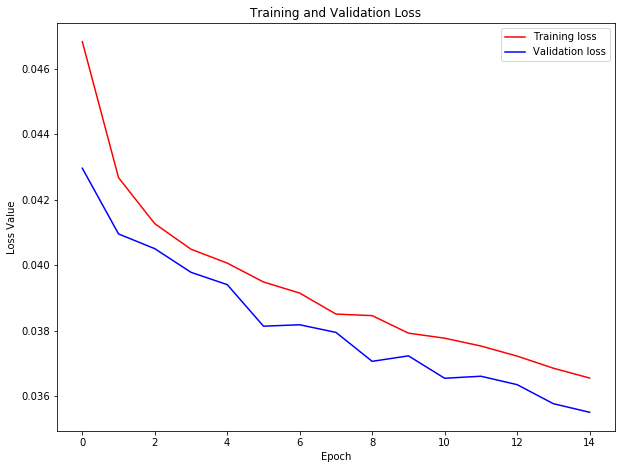

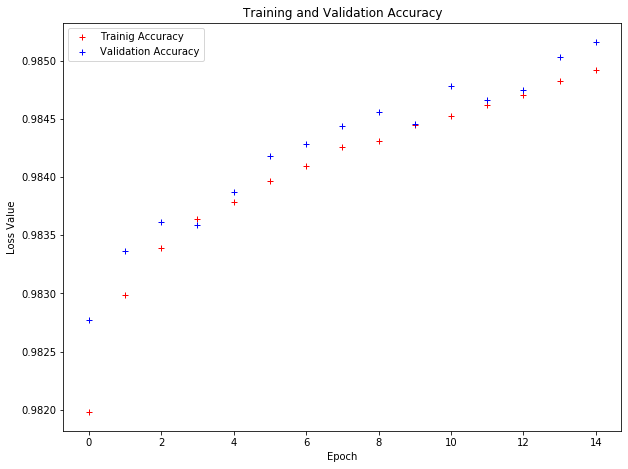

In [5]:
# Define Callback to use created functions
class ModelCallback(tf.keras.callbacks.Callback):
    """
    Callback to show predictions after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.acc = 0
        self.loss = 0
        
    def on_epoch_end(self, epochs, logs=None):
        self.epoch = epochs
        self.acc = logs["accuracy"]
        self.loss = logs["loss"]
        
    def on_test_end(self, logs=None):
        # Show the predicted mask
        pass
        #show_prediction(self.epoch+1)


# Define parameters for training
# Number of epochs
EPOCHS = 15
# Size of training batches
BATCH_SIZE = 40

# Stop training if validation accuracy is no longer increasing
earlystopper = EarlyStopping(patience=3, verbose=1)
#Train the model
history = model.fit(train,
                    label,
                    validation_split=0.1,
                    batch_size=BATCH_SIZE,
                    callbacks=[ModelCallback(), earlystopper],
                    epochs=EPOCHS,
)
# Save the model
SAVEDIR = r"C:/tf_models"
model.save(os.path.join(SAVEDIR, "focus_detector_unet_6x6_256x256_sigmoid.h5"))

# Get training parameters
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
# Plot training parameters
epochs = range(len(loss))
plt.figure(figsize=(10, 7.5))
plt.title("Training and Validation Loss")
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()
plt.figure(figsize=(10, 7.5))
plt.title("Training and Validation Accuracy")
plt.plot(epochs, acc, 'r+', label="Trainig Accuracy")
plt.plot(epochs, val_acc, 'b+', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

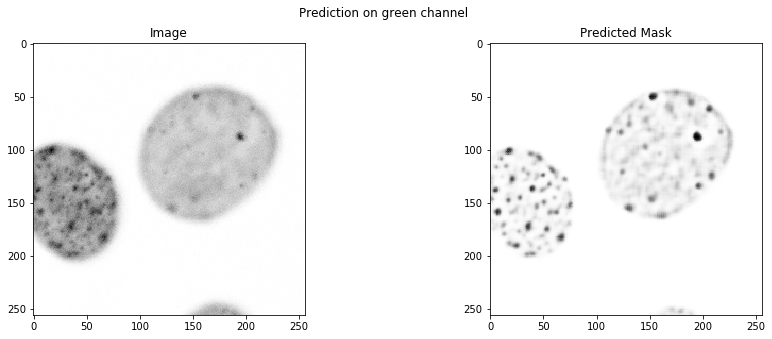

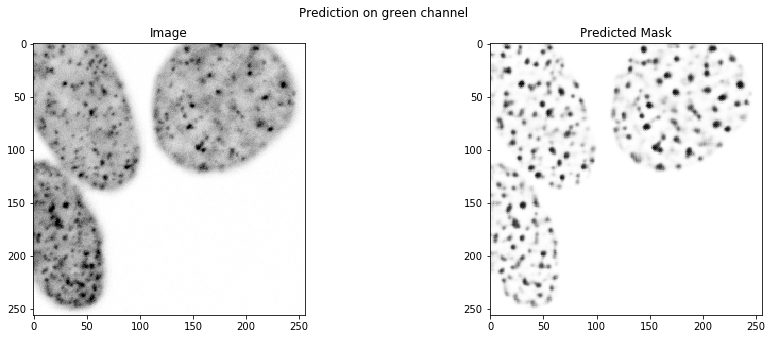

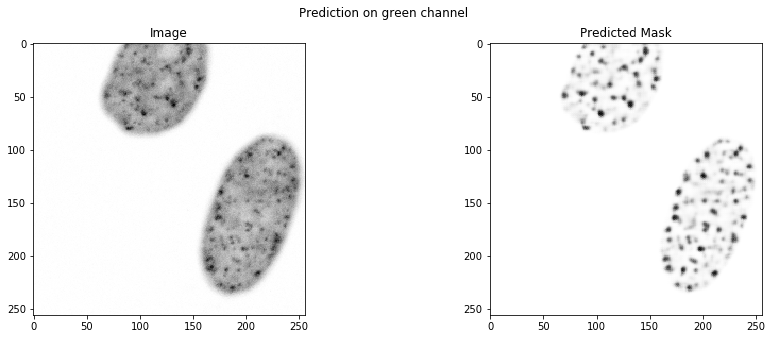

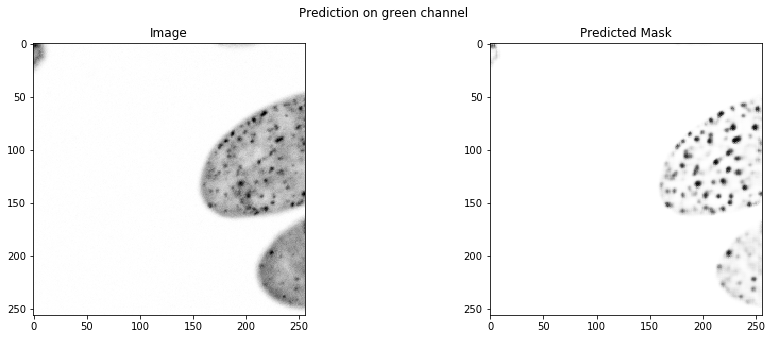

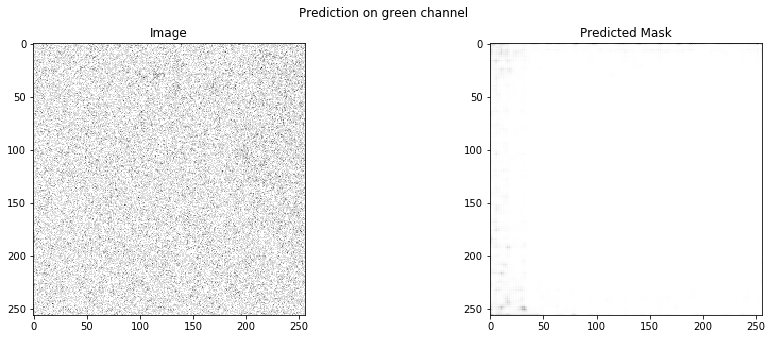

In [6]:
green = []
c = 1
# Load blue channel
for f in os.listdir(train_dir):
    if "Green" in f:
        img = io.imread(os.path.join(train_dir, f))
        if img.shape == (1024, 1024):
            green.append(img[256:512, 256:512])
            c += 1
        if c%6 == 0:
            break

green = np.asarray(green).astype("float32")
green /= 255
green = green.reshape(-1, 256, 256, 1)
for ind in range(2):
    img = green[ind]
    # Create prediction mask for first image
    pred = create_mask(model.predict(img[tf.newaxis, ...]))
    # Create plot
    fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
    fig.suptitle(f"Prediction on green channel")
    ax[0].imshow(tf.keras.preprocessing.image.array_to_img(img), cmap="binary")
    ax[0].set_title("Image")
    ax[1].imshow(tf.keras.preprocessing.image.array_to_img(pred), cmap="binary")
    ax[1].set_title("Predicted Mask")
    plt.show()